ctrl shift f10 - search commands

In [ ]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


In [2]:
from tensorflow import keras
from tensorflow.keras import activations, regularizers, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('TPU')))
tf.debugging.set_log_device_placement(False)

Num GPUs Available:  0


In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
filetype = "Segmented"
numcode = 1
plant = "Tomato"

# Getting the data

terminate session - ram disk 3 dots, manage session, terminate

In [6]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [7]:
!unzip '/content/gdrive/MyDrive/Plants Project/Plants_T_GHL'

Streaming output truncated to the last 5000 lines.
  inflating: Plants_T_GHL/Train/Apple/Apple scab/66__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/67__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/68__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/69__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/7__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/70__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/71__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/72__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/73__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/74__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/75__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/Train/Apple/Apple scab/76__Apple__Apple scab.JPG  
  inflating: Plants_T_GHL/

# temp - count

In [8]:
xpath = '/content/Plants_T_GHL/Train/'+ plant + '/Healthy/'
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))


380


In [9]:
xpath = '/content/Plants_T_GHL/Train/'

In [10]:
import os
c = 0
for folder, subfolders, filenames in os.walk(xpath):
    c += len(filenames)
print(c)

5320


# Some functions

In [11]:
def get_label(file_path, class_names):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The fourth to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)



In [12]:
def decode_img(img, img_height, img_width):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])


In [13]:
def process_path(file_path):
  label = get_label(file_path, class_names)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img, img_height, img_width)
  return img, label


In [14]:
def getfiles(srcpath):
  lfiles = []
  for fol, subfol, files in os.walk(srcpath):
    for file in files:
      lfiles.append(os.path.join(srcpath, os.path.relpath(file)))
  return lfiles

In [15]:
def getinput(src, image_count):
  list_ds = tf.data.Dataset.list_files(str(src), shuffle=True)
  list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)
  val_size = int(image_count * 0.2)
  print(src, 'val size', val_size)
  train_ds = list_ds.skip(val_size)
  val_ds = list_ds.take(val_size)
  print(src, '# train', tf.data.experimental.cardinality(train_ds).numpy())
  print(src, '# test', tf.data.experimental.cardinality(val_ds).numpy())


In [16]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [17]:
def pred(imgpath):
  img = tf.keras.utils.load_img(
      os.path.abspath(imgpath), target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = head_model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  # print(
  #     " {} with a {:.2f} percent confidence."
  #     .format(class_names[np.argmax(score)], 100 * np.max(score))
  # )
  return class_names[np.argmax(score)]

In [18]:
def test_acc(srcpath, classlabel):
  c = 0
  for i in srcpath:
    # print(i, pred(i))
    if classlabel == pred(i):
      c += 1
  return c

# Some parameters

In [19]:
batch_size = 32
img_height = 180
img_width = 180


In [20]:
xpath = '/content/Plants_T_GHL/Train/'+ plant + "/"
data_dir = pathlib.Path(xpath)
print(len(list(data_dir.glob('*'))))
print(data_dir)

4
/content/Plants_T_GHL/Train/Tomato


# Preparing data

In [21]:
image_count = 380 * 4
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True)

In [22]:
for f in list_ds.take(5):
  print(f.numpy())


b'/content/Plants_T_GHL/Train/Tomato/Septoria leaf spot/219__Tomato__Septoria leaf spot.JPG'
b'/content/Plants_T_GHL/Train/Tomato/Leaf mold/294__Tomato__Leaf mold.JPG'
b'/content/Plants_T_GHL/Train/Tomato/Leaf mold/189__Tomato__Leaf mold.JPG'
b'/content/Plants_T_GHL/Train/Tomato/Healthy/236__Tomato__Healthy.JPG'
b'/content/Plants_T_GHL/Train/Tomato/Leaf mold/158__Tomato__Leaf mold.JPG'


In [23]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)


['Early blight' 'Healthy' 'Leaf mold' 'Septoria leaf spot']


In [24]:
print(image_count, image_count*0.2 )

1520 304.0


In [25]:
val_size = int(image_count * 0.2)
print(val_size)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)


304


In [26]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.SkipDataset'>


In [27]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())


1216
304


# Standardize the data

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# total_ds = temp_ds.cache().prefetch(buffer_size=AUTOTUNE)



In [29]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE).shuffle(buffer_size= image_count )
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [30]:
height_factor = [0, 0.1] # between 20%, 30%
width_factor = [0, 0.1]
layer_zoom = tf.keras.layers.RandomZoom(
    height_factor, width_factor=None, fill_mode='reflect',
    interpolation='bilinear', seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_zoom(x), y))
val_ds = val_ds.map(lambda x, y: (layer_zoom(x), y))

factor = [0, 0.05]
layer_rot = tf.keras.layers.RandomRotation(
    factor, fill_mode='reflect', interpolation='bilinear',
    seed=None, fill_value=0.0
)
train_ds = train_ds.map(lambda x, y: (layer_rot(x), y))
val_ds = val_ds.map(lambda x, y: (layer_rot(x), y))



In [31]:
layer_train = tf.keras.layers.experimental.preprocessing.Normalization(axis=None)
train_ds = train_ds.map(lambda x, y: (layer_train(x), y))
# train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (layer_train(x), y))
# val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


In [32]:
for image, label in train_ds.take(5):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0
Image shape:  (180, 180, 3)
Label:  2
Image shape:  (180, 180, 3)
Label:  1
Image shape:  (180, 180, 3)
Label:  3
Image shape:  (180, 180, 3)
Label:  0


# Model

In [33]:
base_model = tf.keras.applications.efficientnet.EfficientNetB5(
    include_top=False, weights='imagenet', classes=class_names, input_shape = (img_height, img_width, 3)
)

115277824/115263384 [==============================] - 1s 0us/step


In [34]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(1000, activation='relu')(x)
predictions = layers.Dense(len(class_names), activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
head_model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [35]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

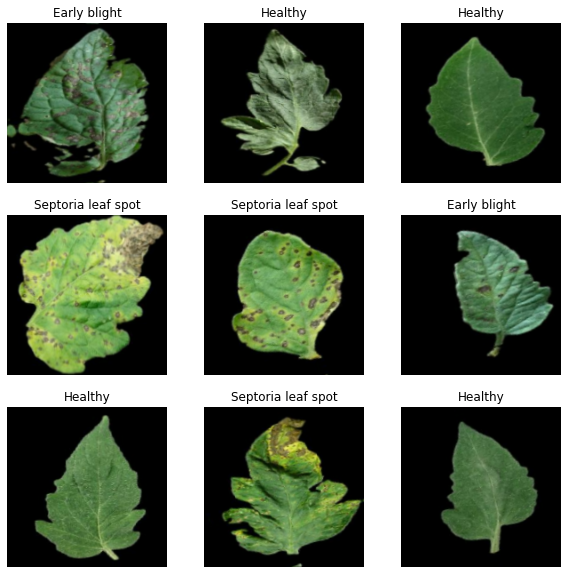

In [36]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")


# Train

In [37]:
epochs=30
history = head_model.fit(train_ds, batch_size = batch_size, epochs=epochs, validation_data=val_ds)


Epoch 1/30
38/38 [==============================] - 76s 922ms/step - loss: 3.6535 - accuracy: 0.6752 - val_loss: 0.9285 - val_accuracy: 0.6776
Epoch 2/30
38/38 [==============================] - 28s 746ms/step - loss: 0.2678 - accuracy: 0.9112 - val_loss: 0.5801 - val_accuracy: 0.7961
Epoch 3/30
38/38 [==============================] - 29s 753ms/step - loss: 0.0748 - accuracy: 0.9737 - val_loss: 0.2586 - val_accuracy: 0.9408
Epoch 4/30
38/38 [==============================] - 29s 761ms/step - loss: 0.1758 - accuracy: 0.9548 - val_loss: 0.8379 - val_accuracy: 0.8158
Epoch 5/30
38/38 [==============================] - 29s 765ms/step - loss: 0.1122 - accuracy: 0.9688 - val_loss: 0.2264 - val_accuracy: 0.9408
Epoch 6/30
38/38 [==============================] - 29s 767ms/step - loss: 0.1450 - accuracy: 0.9597 - val_loss: 0.2526 - val_accuracy: 0.9309
Epoch 7/30
38/38 [==============================] - 29s 764ms/step - loss: 0.1192 - accuracy: 0.9688 - val_loss: 0.2227 - val_accuracy: 0.9342

In [38]:
len(head_model.history.history['accuracy'])

30

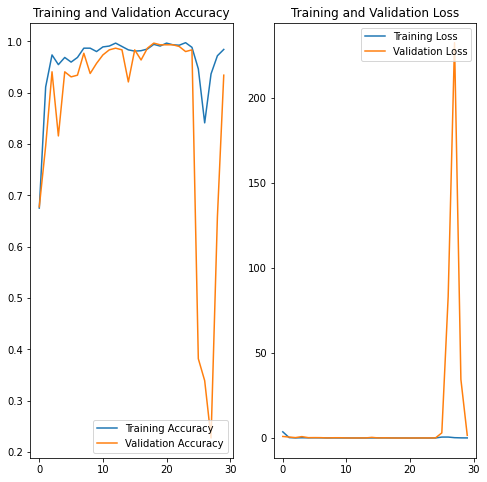

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(head_model.history.history['accuracy']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [40]:
print(acc, val_acc)

[0.6751644611358643, 0.9111841917037964, 0.9736841917037964, 0.9547697305679321, 0.96875, 0.9597039222717285, 0.96875, 0.9868420958518982, 0.9868420958518982, 0.9802631735801697, 0.9893091917037964, 0.9909539222717285, 0.9967105388641357, 0.9901315569877625, 0.9835526347160339, 0.9810855388641357, 0.9819079041481018, 0.9851973652839661, 0.9942434430122375, 0.9909539222717285, 0.9967105388641357, 0.9934210777282715, 0.9925987124443054, 0.9975329041481018, 0.9884868264198303, 0.9465460777282715, 0.8412829041481018, 0.9366776347160339, 0.9720394611358643, 0.984375] [0.6776315569877625, 0.7960526347160339, 0.9407894611358643, 0.8157894611358643, 0.9407894611358643, 0.9309210777282715, 0.9342105388641357, 0.9769737124443054, 0.9375, 0.9572368264198303, 0.9736841917037964, 0.9835526347160339, 0.9868420958518982, 0.9835526347160339, 0.9210526347160339, 0.9835526347160339, 0.9638158082962036, 0.9868420958518982, 0.9967105388641357, 0.9934210777282715, 0.9934210777282715, 0.9934210777282715, 0.

In [ ]:
# import pickle

# with open("/content/gdrive/MyDrive/Project Final year/"+ plant + "_efficientNet_"+str(numcode) + "_"+str(img_width) + 'x' + str(img_height)  +".pkl", "wb") as file:
#   pickle.dump(head_model, file)

# Test

In [ ]:
# head_model = None
# with open("/content/gdrive/MyDrive/Project Final year/" + plant + "_efficientNet_"+str(numcode)+ "_"+str(img_width) + 'x' + str(img_height) +".pkl", "rb") as file:
#   model = pickle.Unpickler(file)
#   global head_model
#   head_model = model.load()

In [ ]:
# print(score)

In [41]:
head_model.save('/content/gdrive/MyDrive/Plants Project/'+ 'eff_'+ plant + "_"+str(numcode) + '.h5')

In [42]:
head_model.save_weights('/content/gdrive/MyDrive/Plants Project/my_checkpoint/'+ plant + "/" +'eff_' +str(numcode) )

In [43]:
diseases = ['Early blight', 'Leaf mold', 'Septoria leaf spot']
imgtypes = [ plant ]
# imgtypes = ['Color', 'GrayScale', 'Segmented']
filesdict = {}
for disease in diseases:
  for imgtype in imgtypes:
      srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+ "//"+disease)
      # print(getfiles(srcpath))
      filesdict[disease+imgtype] = [disease, getfiles(srcpath)]

In [44]:
for k, v in filesdict.items():
  count_ = test_acc(v[1], v[0])
  print(k, count_, count_/len(v[1]))

Early blightTomato 16 0.4
Leaf moldTomato 24 0.6
Septoria leaf spotTomato 34 0.85


In [45]:
# imgtypes = ['Color', 'GrayScale', 'Segmented']
imgtypes = [ plant ]
filesdict = {}
for imgtype in imgtypes:
  srcpath = os.path.join(r'/content/Plants_T_GHL/Test', imgtype+"//Healthy")
  filesdict[imgtype] = [disease, getfiles(srcpath)]
for k, v in filesdict.items():
  count_ = test_acc(v[1], "Healthy")
  print(k, count_, count_/len(v[1]))

Tomato 29 0.725
